# Big Data Coursework

## Data Processing and Machine Learning in the Cloud 

This is the **INM432 Big Data coursework 2021**. 
This coursework extended elements of **theory** and as well as **practical components** . 

## Code and Report

Your tasks are porting, parallelization, extension, evaluation, and theoretical reflection. 
The **coding tasks** are to be completed in (a copy of) **this notebook**. 
Write your code in the **indicated cells** and **include** the **output** in the submitted notebook.  
Make sure that your **code contains comments** on its **stucture** and explanations of its **purpose**. 

Provide also a **report** with the  **textual answers** as indicated **in a separate PDF document**.  
Include **screenshots** from the Google Cloud web interface (don't use the SCREENSHOT function that Google provides, but just take a picture of the graphs you see for the VMs) and result tables, as well as written text about the analysis. 


## Submission

Download and submit **the notebook** as an **.ipynb** file and also as a **shareable link** to your notebook (**don’t change the online version after submission**). 

Further, provide a **PDF report document** with answers containing text, plots, screenshots and tables. **State the number of words** in the document at the end. The report should **not have more than 2000 words**.  



## Introduction and Description

This part of the coursework focuses on parallelisation and scalability in the cloud with Spark and TesorFlow/Keras. 
We start with code based on **lessons 3 and 4** of the [*Fast and Lean Data Science*](https://github.com/GoogleCloudPlatform/training-data-analyst/tree/master/courses/fast-and-lean-data-science) course by Martin Gorner. 
What we will do here is **parallelise** the **pre-processing** and **machine learning** in the cloud and we will perform **evaluation** and **analysis** on the cloud performance, as well as **theoretical discussion**. 

This coursework contains **4 sections**. Section 0 is only about settings and preparations for cloud computing and has no tasks for you (still read the code and comments). 
Section 1 contains tasks about data pre-processing. 
Sections 2 is about machine learning in the cloud. Section 3 contains the theoretical task for discussion. 


### Section 0

This section just contains some necessary code for setting up the environment.

### Section 1 
Section 1 is about reading image files into a dataset and creating TF Record files. 
We will start with an application of some pre-processing steps to a public “Flowers” dataset (3600 images, 5 classes). 
This is not a vast dataset, but it keeps the tasks more manageable and you can scale up later. 

In the **Getting Started** we will work through the code from *Fast and Lean Data Science*. There no task for you here, but you should work through this code before you do the rest.

In **Task 1** we are going to **measure the speed of reading data** in the cloud and we will **parallelise this in Spark**, using Google Cloud (GC) DataProc in **Task 2**. 
For large amounts of training data, the task of creating the TF Record files benefits from parallelisation, which we will also do in Spark in **Task 3**. 

### Section 2

In Section 2, we will **use  pre-processed data** (the public version of the one prepared in Section 1) to train a **deep neural network** in **Tensorflow 2/Keras**. 
We will use transfer learning to take advantage of existing trained models and reduce the training effort. 

We will use the GC **AI-Platform** (formerly Cloud ML) in **Task 4**. 
In contrast to the GC Compute Engine, we can use  machines with GPUs in AI-Platform with free credits. 

### Section 3

This section is about the theoretical discussion, based on to two papers, in **Task 5**. The answers should be given in the PDF report.

### General points

For **all coding tasks**, take the **time of the operations** and for the cloud operations, get performance **information from the web interfaces** for your reporting and analysis. 

The **tasks** are **mostly independent**. The later tasks can mostly be addressed without needed the solution to the earlier ones.  

# Section 0: Set-up

You need to run the imports and authentication every time you work with this notebook. 
Use the local Spark installation and word count as needed. 

### Imports

We import some packages that we will need throughout.  For the cloud you will need separate import sections, that will need to be partly different from that below. 


In [ ]:
import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import string
import random
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle
AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

Tensorflow version 2.4.1


### Cloud and Drive authentication

This is for authenticating with Google Drive and with GCS, so that we can create and use our own buckets and access DataProc and AI-Platform. 

This section starts with two interactive authentications.

First, we mount Google Drive for persistent local storage and create a directory `DB-CW2` to use for this work. 
Then we'll set up the cloud environment, including a storage bucket.

In [ ]:
print('Mounting google drive...')
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive"
!mkdir BD-CW
%cd "/content/drive/MyDrive/BD-CW"

Mounting google drive...
Mounted at /content/drive
/content/drive/MyDrive
mkdir: cannot create directory ‘BD-CW’: File exists
/content/drive/MyDrive/BD-CW


Next, we authenticate with the cloud system to enable access to DataProc and AI-Platform.

In [ ]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

It is useful to create a new Google Cloud project for this coursework. You can do this on the [GC Console page](https://console.cloud.google.com) by clicking on the entry at the top, right of the *Google Cloud Platform* and choosing *New Project*. **Copy** the **generated project ID** to the next cell.

We also specify the **default project and region**. The REGION should be `us-central1` as that seems to be the only one that reliably works with the free credit. 
This way we don't have to specify this information every time we access the cloud.  

In [ ]:
PROJECT = 'big-data-21-cw' ### Append -xxxx, where xxxx is your City login ###
### it seems that the project name here has the be all lower case.
!gcloud config set project $PROJECT
REGION = 'us-central1'
!gcloud config set compute/region $REGION
!gcloud config set dataproc/region $REGION

!gcloud config list # show some information

Updated property [core/project].
Updated property [compute/region].
Updated property [dataproc/region].
[component_manager]
disable_update_check = True
[compute]
gce_metadata_read_timeout_sec = 0
region = us-central1
[core]
account = t.e.weyde@city.ac.uk
project = big-data-21-cw
[dataproc]
region = us-central1

Your active configuration is: [default]


With the cell below, we **create a storage bucket** that we will use later for **global storage**. 
If the bucket exists you will see a "ServiceException: 409." This is not a problem, just a sign the bucket is already there. 
**You must create your own bucket to have write access.**

In [ ]:
BUCKET = 'gs://{}-storage'.format(PROJECT)
!gsutil mb $BUCKET

The cell below just **defines some routines for displaying images** that will be **used later**. You can see the code by double-clicking, but you don't need to study this.

In [ ]:
#@title "Display utility functions [RUN THIS TO ACTIVATE]" { display-mode: "form" }
def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))   
    plt.title(str(label.numpy()), fontsize=16)
    # plt.title(label.numpy().decode(), fontsize=16)
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

def dataset_to_numpy_util(dataset, N):
    dataset = dataset.batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1

def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  classes = np.argmax(predictions, axis=-1)
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(classes[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  

### Optional: Install Spark locally for quick testing

You can use the cell below to install a local spark as in the labs, to do quicker small-scale interactive testing. Using the cloud is still required for the final version. 


In [ ]:
%cd
!apt-get update -qq
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget -q https://archive.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
#!tar -xzf spark-3.0.1-bin-hadoop2.7.tgz
!tar -xzf /content/drive/MyDrive/Big_Data/data/spark-3.0.1-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/root/spark-3.0.1-bin-hadoop2.7"
import findspark
findspark.init()
%cd /content
import pyspark
print(pyspark.__version__)
sc = pyspark.SparkContext.getOrCreate()
print(sc)

/root
^C
/content
3.0.1
<SparkContext master=local[*] appName=pyspark-shell>


# Section 1: Data pre-processing

This section is about the **pre-processing of a dataset** for deep learning with Keras/Tensorflow. 
The tasks are about **parallelisation** and **analysis** the performance of the cloud services. 

## Getting started 

In this section, we get started based on the code from lecture 3 of the 'Fast and Lean Data Science' course to establish the task.


These are some variables with **settings for the *Flowers* dataset**.

In [ ]:
GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
SHARDS = 16 # shards are partitiones into shards
TARGET_SIZE = [192, 192] # the resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']
    # labels for the data (folder names)

###Read images and labels

We **read the image files** from a public GCS bucket that contains the *Flowers* dataset. 
**TensorFlow**  has **functions** to process standard **image files**. The `decode_jpeg_and_label` function also extracts the label name from the path. 

In [ ]:
nb_images = len(tf.io.gfile.glob(GCS_PATTERN)) 
shard_size = math.ceil(1.0 * nb_images / SHARDS)
print("Pattern matches {} images which will be rewritten as {} .tfrec files containing {} images each.".format(nb_images, SHARDS, shard_size))

def decode_jpeg_and_label(filepath):
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

filepathDS = tf.data.Dataset.list_files(GCS_PATTERN) # This also shuffles the images
dataset1 = filepathDS.map(decode_jpeg_and_label)
for x in dataset1.take(1):
    print(x) # show what's in a data item

Pattern matches 3670 images which will be rewritten as 16 .tfrec files containing 230 images each.
(<tf.Tensor: shape=(240, 240, 3), dtype=uint8, numpy=
array([[[ 95, 125,  65],
        [ 94, 124,  64],
        [ 91, 123,  60],
        ...,
        [ 86, 118,  42],
        [ 90, 121,  51],
        [ 78, 107,  41]],

       [[ 95, 125,  65],
        [ 94, 125,  65],
        [ 93, 124,  64],
        ...,
        [ 84, 118,  42],
        [ 87, 118,  50],
        [ 73, 103,  39]],

       [[ 93, 122,  64],
        [ 93, 124,  65],
        [ 92, 123,  64],
        ...,
        [ 82, 119,  42],
        [ 82, 115,  46],
        [ 65,  97,  32]],

       ...,

       [[ 53,  83,  23],
        [ 54,  84,  24],
        [ 54,  84,  22],
        ...,
        [  9,  33,   0],
        [ 10,  34,   0],
        [ 11,  35,   0]],

       [[ 56,  86,  26],
        [ 56,  86,  26],
        [ 56,  86,  24],
        ...,
        [  9,  33,   0],
        [ 10,  35,   0],
        [ 11,  36,   0]],

       [[

Now we can **have a look** at the images with one of the display functions. Note the **different aspect ratios**.

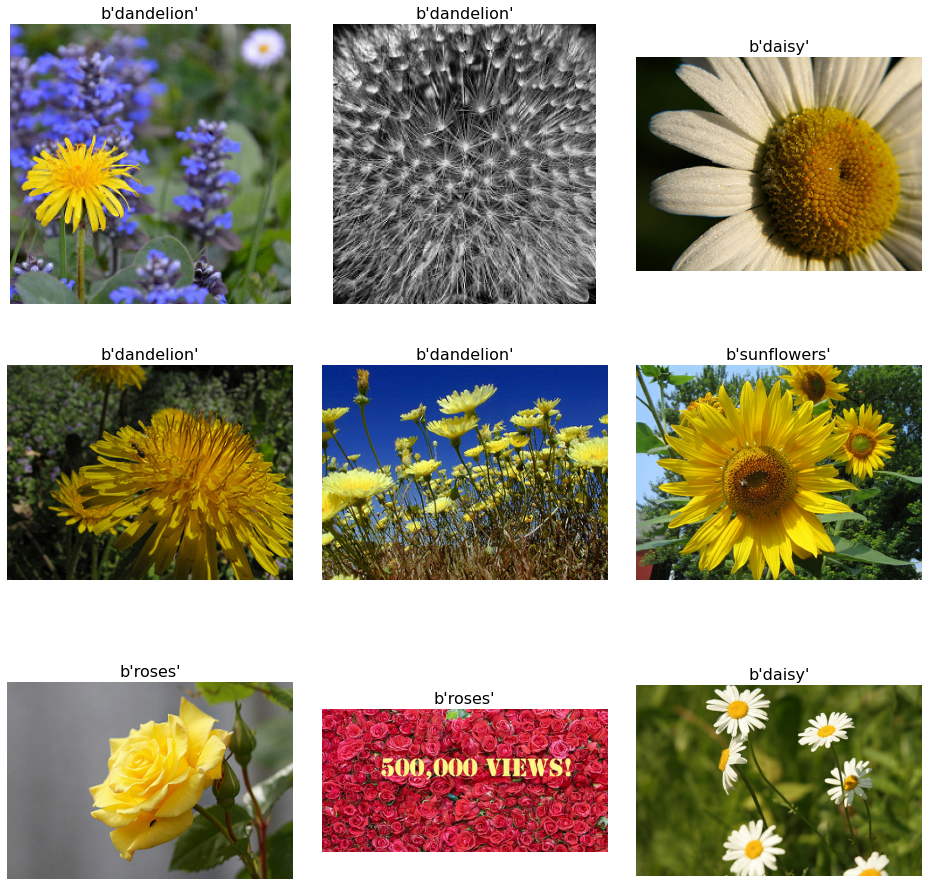

In [ ]:
display_9_images_from_dataset(dataset1)

### Resize and crop images to common size

Standard Neural Networks, like most machine learning algorithms, need **fixed size input items**. 
We achieve this here by resizing and cropping the images to a common target resolution.

In [ ]:
def resize_and_crop_image(image, label):
  # Resize and crop using "fill" algorithm:
  # always make sure the resulting image
  # is cut out from the source image so that
  # it fills the TARGET_SIZE entirely with no
  # black bars and a preserved aspect ratio.
  w = tf.shape(image)[0]
  h = tf.shape(image)[1]
  tw = TARGET_SIZE[1]
  th = TARGET_SIZE[0]
  resize_crit = (w * th) / (h * tw)
  image = tf.cond(resize_crit < 1,
                  lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                  lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                 )
  nw = tf.shape(image)[0]
  nh = tf.shape(image)[1]
  image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
  return image, label
  
dataset2 = dataset1.map(resize_and_crop_image)  

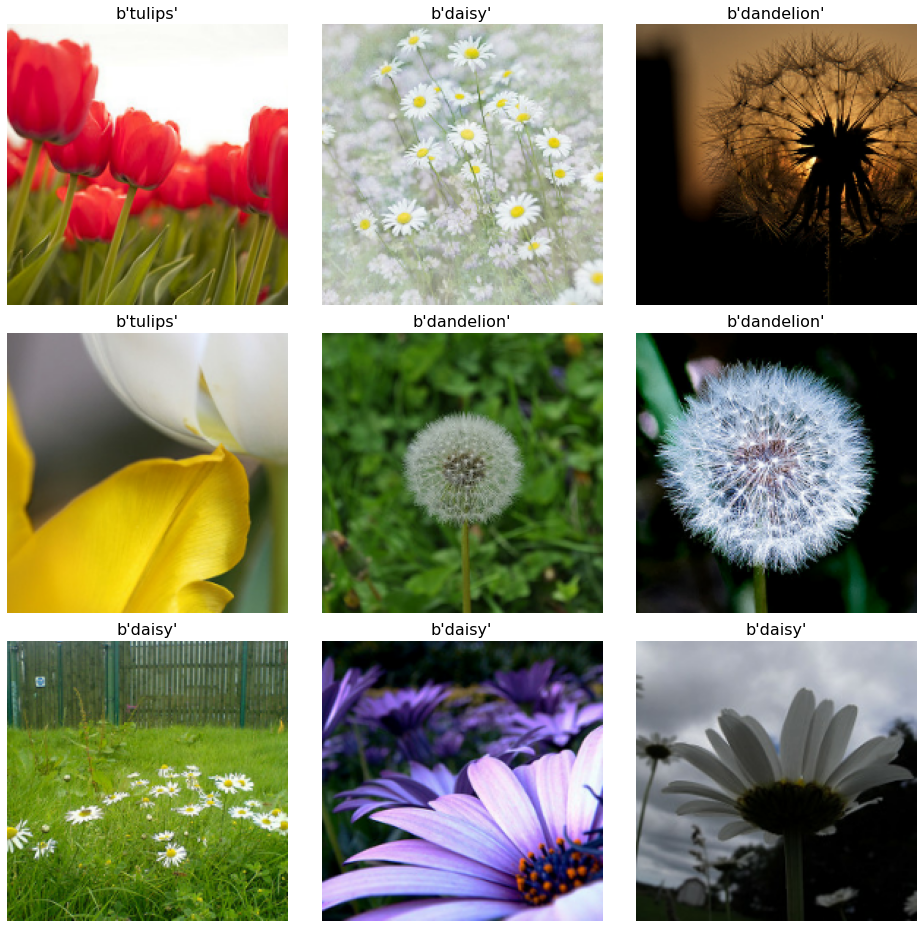

In [ ]:
display_9_images_from_dataset(dataset2)

Now test continuous reading from the dataset.

In [ ]:
batched_dataset = dataset2.batch(8)
sample_set = batched_dataset.take(20)
for image, label in sample_set: 
    print("Image batch shape {}, {})".format(image.numpy().shape,
        [lbl.decode('utf8') for lbl in label.numpy()]))

Image batch shape (8, 192, 192, 3), ['sunflowers', 'sunflowers', 'roses', 'sunflowers', 'roses', 'sunflowers', 'tulips', 'tulips'])
Image batch shape (8, 192, 192, 3), ['tulips', 'daisy', 'dandelion', 'sunflowers', 'roses', 'daisy', 'dandelion', 'daisy'])
Image batch shape (8, 192, 192, 3), ['dandelion', 'tulips', 'daisy', 'dandelion', 'daisy', 'tulips', 'dandelion', 'dandelion'])
Image batch shape (8, 192, 192, 3), ['sunflowers', 'sunflowers', 'daisy', 'daisy', 'dandelion', 'sunflowers', 'daisy', 'dandelion'])
Image batch shape (8, 192, 192, 3), ['dandelion', 'daisy', 'sunflowers', 'sunflowers', 'tulips', 'sunflowers', 'tulips', 'dandelion'])
Image batch shape (8, 192, 192, 3), ['daisy', 'sunflowers', 'dandelion', 'tulips', 'daisy', 'tulips', 'daisy', 'daisy'])
Image batch shape (8, 192, 192, 3), ['roses', 'dandelion', 'dandelion', 'dandelion', 'tulips', 'sunflowers', 'daisy', 'sunflowers'])
Image batch shape (8, 192, 192, 3), ['sunflowers', 'daisy', 'tulips', 'sunflowers', 'tulips', 

## Improving Speed 

Using individual image files didn't look very fast. The 'Lean and Fast Data Science' course introduced **two techniques to improve the speed**.


### Recompress the images

By **compressing** the images in the **reduced resolution** we save on the size. 
This **costs some CPU time**, but **saves network and disk bandwith**, especially when the data are **read multiple times**. 


In [ ]:
def recompress_image(image, label):
  height = tf.shape(image)[0]
  width = tf.shape(image)[1]
  image = tf.cast(image, tf.uint8)
  image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
  return image, label, height, width

dataset3 = dataset2.map(recompress_image)
dataset4 = dataset3.batch(shard_size) # sharding: there will be one "batch" of images per file 

In [ ]:
# This is a quick test to get an idea how long recompressions takes.  
BATCH_SIZE = 8
dataset4 = dataset3.batch(BATCH_SIZE)
BATCH_NUMBER = 3 # number of batches
test_set = dataset4.take(BATCH_NUMBER)
for image, label, height, width in test_set:
    print("Image batch shape {}, {})".format(image.numpy().shape, [lbl.decode('utf8') for lbl in label.numpy()])) 

Image batch shape (8,), ['tulips', 'sunflowers', 'daisy', 'sunflowers', 'sunflowers', 'sunflowers', 'tulips', 'tulips'])
Image batch shape (8,), ['dandelion', 'dandelion', 'dandelion', 'sunflowers', 'tulips', 'daisy', 'sunflowers', 'tulips'])
Image batch shape (8,), ['tulips', 'roses', 'tulips', 'tulips', 'tulips', 'daisy', 'tulips', 'dandelion'])


### Write the dataset to TFRecord files

By writing **multiple samples into a single file**, we can make further speed gains.

There are **ready-made pre-processed data** versions available, e.g. here: 
`gs://flowers-public/tfrecords-jpeg-192x192-2/`, that we can use for comparison and later use.

First we need to **define a location** where we want to put the file. 


In [ ]:
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'  # prefix for output file names

NameError: ignored

Now we can **write the TFRecord files** to the bucket. 

Running the cell takes some time and **only needs to be done once** or not at all, as you can use the publicly available data for the next few cells. 

In [ ]:
# functions for writing TFRecord entries
# Feature values are always stored as lists, a single data element will be a list of size 1
def _bytestring_feature(list_of_bytestrings):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
  return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))  

def to_tfrecord(tfrec_filewriter, img_bytes, label): #, height, width):  
  class_num = np.argmax(np.array(CLASSES)==label) # 'roses' => 2 (order defined in CLASSES)
  one_hot_class = np.eye(len(CLASSES))[class_num]     # [0, 0, 1, 0, 0] for class #2, roses
  feature = {
      "image": _bytestring_feature([img_bytes]), # one image in the list
      "class": _int_feature([class_num]) #,        # one class in the list
  }
  return tf.train.Example(features=tf.train.Features(feature=feature))
  
print("Writing TFRecords")
tt0 = time.time()
filenames = tf.data.Dataset.list_files(GCS_PATTERN) 
dataset1 = filenames.map(decode_jpeg_and_label)
dataset2 = dataset1.map(resize_and_crop_image)  
dataset3 = dataset2.map(recompress_image)
dataset3 = dataset3.batch(shard_size) # sharding: there will be one "batch" of images per file 
for shard, (image, label, height, width) in enumerate(dataset3):
  # batch size used as shard size here
  shard_size = image.numpy().shape[0]
  # good practice to have the number of records in the filename
  filename = GCS_OUTPUT + "{:02d}-{}.tfrec".format(shard, shard_size)
  # You need to change GCS_OUTPUT to your own bucket to actually create new files  
  with tf.io.TFRecordWriter(filename) as out_file:
    for i in range(shard_size):
      example = to_tfrecord(out_file,
                            image.numpy()[i], # re-compressed image: already a byte string
                            label.numpy()[i] #, height.numpy()[i], width.numpy()[i]
                            )
      out_file.write(example.SerializeToString())
    print("Wrote file {} containing {} records".format(filename, shard_size))
print("Total time: "+str(time.time()-tt0))

Writing TFRecords


NameError: ignored

### Test the TFRecord files

We can now **read from the TFRecord files**. By default, we use the files in the public bucket. Comment out the 1st line of the cell below to use the files written in the cell above.

In [ ]:
GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/' # remove/change to use your own files

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
  # read from TFRecords. For optimal performance, read from multiple    
  # TFRecord files at once and set the option experimental_deterministic = False
  # to allow order-altering optimizations.
  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord)
  return dataset

    
filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
datasetDecoded = load_dataset(filenames)

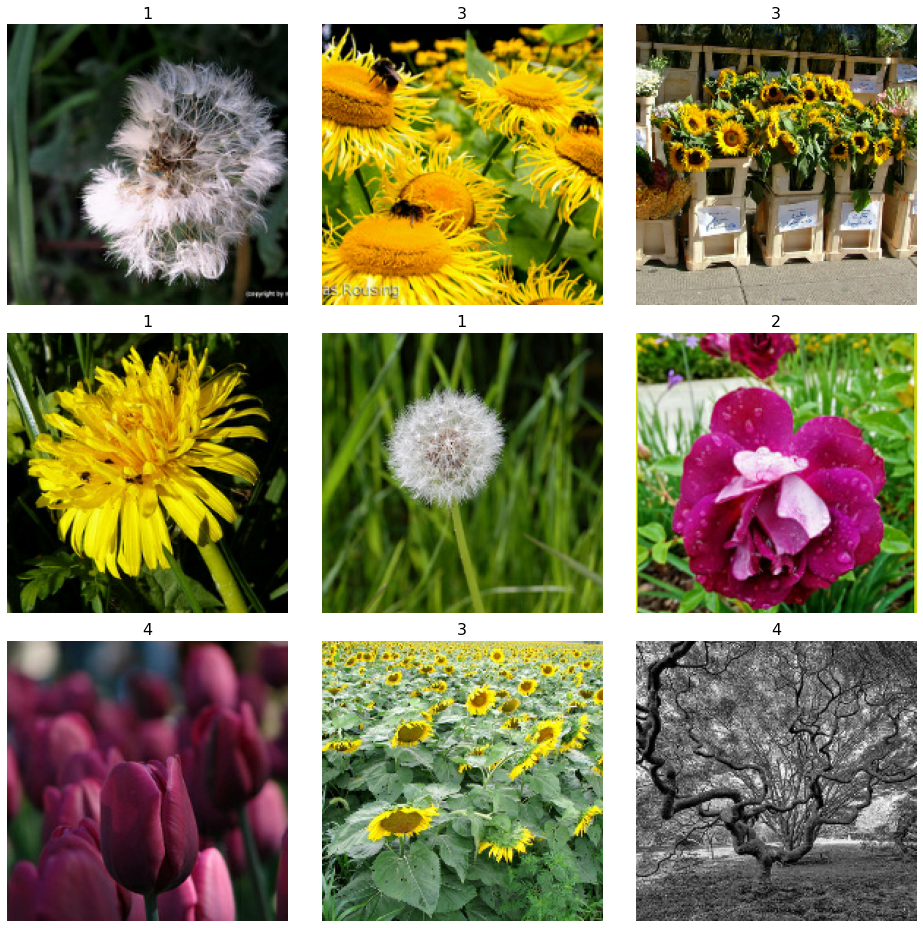

In [ ]:
display_9_images_from_dataset(datasetDecoded)

Let's have a look **if reading from the TFRecord** files is **quicker**. 

In [ ]:
batched_dataset = datasetDecoded.batch(8)
sample_set = batched_dataset.take(20)

for image, label in sample_set: 
    print("Image batch shape {}, {})".format(image.numpy().shape, \
                        [str(lbl) for lbl in label.numpy()]))
    
for image, label in sample_set: 
    print("Image batch shape {}, {})".format(image.numpy().shape, \
                        [str(lbl) for lbl in label.numpy()]))

Image batch shape (8, 192, 192, 3), ['1', '3', '3', '1', '1', '2', '4', '3'])
Image batch shape (8, 192, 192, 3), ['4', '3', '3', '0', '3', '4', '2', '2'])
Image batch shape (8, 192, 192, 3), ['3', '2', '0', '3', '4', '4', '4', '1'])
Image batch shape (8, 192, 192, 3), ['3', '2', '4', '4', '4', '3', '1', '3'])
Image batch shape (8, 192, 192, 3), ['4', '1', '1', '4', '2', '2', '3', '2'])
Image batch shape (8, 192, 192, 3), ['0', '4', '3', '4', '0', '1', '2', '1'])
Image batch shape (8, 192, 192, 3), ['2', '0', '1', '1', '1', '2', '0', '0'])
Image batch shape (8, 192, 192, 3), ['1', '4', '3', '1', '1', '2', '0', '2'])
Image batch shape (8, 192, 192, 3), ['3', '4', '2', '1', '1', '0', '0', '1'])
Image batch shape (8, 192, 192, 3), ['1', '3', '1', '0', '1', '3', '3', '3'])
Image batch shape (8, 192, 192, 3), ['3', '3', '3', '1', '1', '2', '0', '3'])
Image batch shape (8, 192, 192, 3), ['0', '1', '0', '0', '1', '1', '1', '0'])
Image batch shape (8, 192, 192, 3), ['1', '4', '3', '2', '2', '1

## Task1: Cloud Speed tests (8%)

We have just seen that **reading from the pre-processed TFRecord files** is **faster** than reading individual image files and decoding on the fly. 
This task is about **understanding and quantifying this effect** better. 

### 1a): Speed test (5%)

Start by implementing **code for time measurement** to determine the **throughput in images per second**. 
Don't render the images, just print some basic information in order to **avoid measuring image rendering time**. 
It's useful to write to the null device for longer measurements (e.g. 
`print('string', \ file=open("/dev/null",mode='w')`).

Use batches ( `dataset.batch(batch_size)` ) and select a sample with (`dataset.take(batch_number)`). 
Good starting values are 8 and 10, i.e. we take 10 batches of 8 samples each. 

Use the `time.time()` to take the **time measurement** and take it multiple times, reading from the same dataset. 

**Vary** the size of the batch (`batch_size`) and the number of batches (`batch_number`) and **store the results for different values**. 
Store also the **results for each repetition** over the same dataset (repeat 2 or 3 times).

The speed test should be packaged into a **function** `time_configs()` that takes a dataset and the batch_sizes, batch_numbers, and number of repetitions as **arguments** to run a series of tests. 



In [ ]:
# Here are some useful values for testing
#batch_sizes = [2,4] 
#batch_number = [3,6] 
#repetitions = [1,2] 

import pandas as pd 
import time 
def time_configs(dataset, batch_sizes, batch_numbers, repetitions):
    time1 = []
    batch_sizes = []
    batch_number = []
    repetitions = []
    for s in batch_sizes:
        for n in batch_number:
            batched_dataset = dataset.batch(s)
            sample_set =batched_dataset.take(n)
            for r in repetitions:
                for ra in range(r):
                    t0 = time.time()
                    for image, label in sample_set:
                        print("", file=open("/dev/null", mode='w'))
                        t1 = time.time()-t0
                time1.append(t1)
                batch_sizes.append(s)
                batch_number.append(n)
                repetions.append(r)
    dict = {"time": time1, "batchsizes": batch_sizes, "batchnumber": batch_number, "repetitions": repetitions}
    df = pd.DataFrame(dict)
    return (df)
            
                
                        
    

### CODING TASK ###

**Try your function** with a **small number** of configurations of batch_sizes batch_numbers and repetions, so that we get a set of parameter combinations and corresponding reading speeds.
Try reading from the image files (dataset2) and the TFRecord files (datasetDecoded).



In [ ]:
### CODING TASK ###
# configurations
batch_sizes = [2, 4, 8] 
batch_numbers = [3, 6, 10] 
repetitions = [1, 2] 

# reading images from dataset2

tcd2=time_configs(dataset2, batch_sizes, batch_numbers, repetitions)
tcd2

In [ ]:
# configurations 
batch_sizes = [2, 4, 8] 
batch_numbers = [3, 6, 10] 
repetitions = [1, 2] 

# reading from TFRecord files(datasetDecoded)
tcdD=time_configs(datasetDecoded, batch_sizes, batch_numbers, repetitions)
tcdD

### 1b) Speed test analysis (3%)

Do a **linear regression** over pre-processing and reading **speed** as a **function of parameter values**. Look at the parameters `batch_size`, `batch_number`, `repetition` and the dataset size (`batch_size * batch_number`). 

This needs to be done **separately for the two datasets**. 

**Print** the regression results (slope, intercept, pvalue etc) and **plot** the measurements and the regression line for each of the 4 parameters. 


In [ ]:
### CODING TASK ###
tcdD['datasetsize']=tcdD['batch_numbers']*tcdD['batch_sizes']
tcdD

In [ ]:
y=tcdD.iloc[:,0]
y
x=tcdD.iloc[:,1:]
x
import statsmodels.api as sm
results = sm.OLS(y,x).fit()
results.summary()

In [ ]:
tcdD

In [ ]:
from statistics import mean
time=[]
batch_sizes = []
for i in np.unique(tcdD['batch_sizes']):
    batch_sizes.append(i)
    c=mean(tcdD[tcdD['batch_sizes']==i].time)
    time.append(c)
    
    
# using seaborn to plot regression results
import seaborn as sb
fig = plt.figure(figsize=(10, 7))
sb.regplot(x=batch_sizes, y=time, color='blue', marker='+')
plt.title('batch_sizes and time relationships', size=24)
plt.xlabel('batch_sizes', size=18)
plt.ylabel('time', size=18)


In [ ]:
from statistics import mean
time=[]
batch_sizes = []
for i in np.unique(tcdD['batch_numbers']):
    batch_sizes.append(i)
    c=mean(tcdD[tcdD['batch_numbers']==i].time)
    time.append(c)
    
    
# using seaborn to plot regression results
import seaborn as sb
fig = plt.figure(figsize=(10, 7))
sb.regplot(x=batch_sizes, y=time, color='blue', marker='+')
plt.title('batch_numbers and time relationships', size=24)
plt.xlabel('batch_numbers', size=18)
plt.ylabel('time', size=18)

In [ ]:
from statistics import mean
time=[]
batch_sizes = []
for i in np.unique(tcdD['repetitions']):
    batch_sizes.append(i)
    c=mean(tcdD[tcdD['repetitions']==i].time)
    time.append(c)
    
    
# using seaborn to plot regression results
import seaborn as sb
fig = plt.figure(figsize=(10, 7))
sb.regplot(x=batch_sizes, y=time, color='blue', marker='+')
plt.title('repetitions and time relationships', size=24)
plt.xlabel('repetitions', size=18)
plt.ylabel('time', size=18)

In [ ]:
from statistics import mean
time=[]
batch_sizes = []
for i in np.unique(tcdD['datasetsize']):
    batch_sizes.append(i)
    c=mean(tcdD[tcdD['datasetsize']==i].time)
    time.append(c)
    
    
# using seaborn to plot regression results
import seaborn as sb
fig = plt.figure(figsize=(10, 7))
sb.regplot(x=batch_sizes, y=time, color='blue', marker='+')
plt.title('datasetsize and time relationships', size=24)
plt.xlabel('datasetsize', size=18)
plt.ylabel('time', size=18)

## Task 2: Parallelising the speed test with Spark in the cloud. (32%)

As an exercise in **Spark programming and optimisation** as well as **performance analysis**, we will now implement the **speed test** with multiple parameters in parallel with Spark. 
Runing mutliple tests in parallel would **not be a useful approach on a single machine, but it can be in the cloud** (you will be asked to reason about this later). 


### Preparation: Running Spark in the cloud 

In order to test multiple configurations, especially with reasonably large datasets, we will use **Spark** to run **multiple tests in parallel**. 
We will start by looking at **how to use Spark on GCS Dataproc**. 

This section shows you in detail **how to run Python code in Dataproc**. 
You may need to **enable the Dataproc API** on the [console Dataproc page](https://console.cloud.google.com/dataproc/clusters/), if you have not done so, yet. 

First we need to **create a cluster**. We start with a single machine, just to try it out. 

We are using the `gcloud dataproc clusters` command. [Click here for documentation](https://cloud.google.com/sdk/gcloud/reference/dataproc/clusters). 
The **parameter** `--image-version 1.4-ubuntu18` makes sure we get **intended software**. 

Starting a cluster **can take a few minutes**. You can wait for the cell to finish processing or interrupt its execution and check on the [console Dataproc page](https://console.cloud.google.com/dataproc/clusters/) if the cluster is ready.


In [ ]:
CLUSTER = '{}-cluster'.format(PROJECT)
!gcloud dataproc clusters create $CLUSTER \
    --image-version 1.4-ubuntu18 --single-node \
    --master-machine-type n1-standard-2 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100 \
    --max-idle 3600s 

The `--max-idle 3600s` flag means that the cluster will be **deleted automatically** once it has been **idle for 1 hour**. This helps minimising costs for a cluster left running by accident. 

This is a single-node cluster. This is created a bit more quickly than a multi-node cluster, but set-up is still quite slow (several minutes) because of the **restrictions on the free tier**. 
You **can switch to paid tier** and still use your free credit, but then you **may use up your free credit more quickly** and have to **pay for usage**.
If you stay in the free tier Google promises not to charge you. The free tier resources are sufficient for this coursework, if you use the local Spark installation for testing and set parameters with care. All the development of this coursework was done with a free tier account. 

We have not specified the region (we could have used `--region $REGION`) as we set already the default for Dataproc in the beginning. 

You can run the **command below to get extensive information** about your running cluster. 
However, it is usually **more practical** to look at the [console Dataproc page](https://console.cloud.google.com/dataproc/clusters/). 
You can check the details and current state of your cluster by clicking on its name. 
Double-check there at the end of your working session to make sure that no clusters are left running, especially when you are not in free mode any more. 

In [ ]:
!gcloud dataproc clusters describe $CLUSTER 

Now that our cluster is running, we can submit a Spark job. A minimal Spark job is just a Python script. A simple "Hello World" Spark script is provided in a public cloud bucket. Let's have a look at it:

In [ ]:
!gsutil cat gs://dataproc-examples/pyspark/hello-world/hello-world.py 

... and run it on the cluster. We submit the job with the `gcloud dataproc jobs` command ([click here for the documentation](https://cloud.google.com/sdk/gcloud/reference/dataproc/jobs)) with the cluster name.


In [ ]:
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER \
    gs://dataproc-examples/pyspark/hello-world/hello-world.py 

The `trackingUrl` shown above will only work as long as the job is running. On to the [dataproc page](https://console.cloud.google.com/dataproc/clusters/), you can click through to your cluster page and from there to your job page to see details on past jobs.

You may get some warnings like this: 
`WARN org.apache.spark.scheduler.FairSchedulableBuilder: Fair' ...
or this one:
`WARN org.apache.hadoop.hdfs.DataStreamer: Caught exception`. There was not enough time to research these fully but they don't affect what we do here and can be ignored. 

One issue is that we need to **get output data from the cluster back to the notebook**. We can output text through printing into the output stream, but that does not work well for scaling up, for automation or for binary data. 

A better solution is to **pass an argument** to the job, to tell the job on the cluster **where to write the output**. 
This requires a bit of extra code as shown below using the argparse package.
The example below the checks if the script runs in Colab and if that is the case, it does not execute the run function. 
This is useful for quick testing with a local spark instance.

For running the file in DataProc, write to a local file `hello-world.py`, uncomment the  the `%%writefile` magic as in the cell below.


In [ ]:
#%%writefile hello-world.py

import sys
import pyspark
import argparse
import pickle 

def save(object,bucket,filename):
    with open(filename,mode='wb') as f:
        pickle.dump(object,f)
    print("Saving {} to {}".format(filename,bucket))
    import subprocess
    proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
    print("gstuil returned: " + str(proc.returncode))
    print(str(proc.stderr))

def runWordCount(argv): 
    # Parse the provided arguments
    print(argv)
    parser = argparse.ArgumentParser() # get a parser object
    parser.add_argument('--out_bucket', metavar='out_bucket', required=True,
                        help='The bucket URL for the result.') # add a required argument
    parser.add_argument('--out_file', metavar='out_file', required=True,
                        help='The filename for the result.') # add a required argument
    args = parser.parse_args(argv) # read the value
    # the value provided with --out_bucket is now in args.out_bucket
    sc = pyspark.SparkContext.getOrCreate()
    rdd = sc.parallelize(['Hello,', 'world!'])
    words = sorted(rdd.collect())
    save(words,args.out_bucket,args.out_file)

if  'google.colab' not in sys.modules: # Don't use system arguments run in Colab 
    runWordCount(sys.argv[1:])  
elif __name__ == "__main__" : # but define them manually
    runWordCount(["--out_bucket", BUCKET, "--out_file", "words.pkl"])

**Once the code works as intended**, you can write it to the local disk (on your Colab instance). For this, **uncomment the first line with the `%%writefile` magic** and then **re-run the cell**. 

Then **check** that the file **is in the current directory** and **has the right contents** like this:

In [ ]:
!pwd
!ls -l hello-world.py
!cat hello-world.py

We can now submit the job with an extra section for application arguments. It's started by `--`, which indicates that all following arguments are to be sent to our Spark application. 

In [ ]:
FILENAME = 'words.pkl'
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region $REGION \
    ./hello-world.py \
    -- --out_bucket $BUCKET --out_file $FILENAME

Once the job has finished, we can **use the output** by **copying it from the bucket** and **reading it as a local file**.

In [ ]:
# Make sure you are writing to the right directory
%cd /content/drive/MyDrive/BD-CW
!gsutil cp $BUCKET/$FILENAME . 
!ls -l
with open(FILENAME,mode='rb') as f:
    words = pickle.load(f) 

print("Content of {} : {}".format(FILENAME,words))

At the end of a session we should **delete the cluster**, as it incurs a **cost for the time** it runs.  

In [ ]:
!gcloud dataproc clusters delete $CLUSTER -q 
# the -q flag disables the confirmation prompt 
# , we want to make sure it really gets deleted

### 2a) Create the script (12%)
Your task is now to **port the speed test to Spark** for running it in the cloud in DataProc. 
**Adapt the preprocessing code** as a Spark programm that performs the same actions as above, but **with Spark RDDs in a distributed way**. 
The distribution should be such that **each parameter combination (except repetition)** is processed in a separate Spark task.

More specifically: 
*   i) combine the previous cells to have the code to create a dataset and create a list of parameter combinations in an RDD (2%)
*   ii) get a spark context and  create the dataset and run timing test for each combination in parallel (2%)
*   iii) transform the resulting RDD to the structure \( parameter_combination, images_per_second \) and save these values in an array (2%)
*   iv) create an RDD with all results for each parameter as (parameter_value,images_per_second) and collect the result for each parameter  (1%)
*   v) create an RDD with the average reading speeds for each paramter value and collect the results. Keep associativity in mind when implementing the average. (3%) 
*   vi) write the results to a pickle file in your bucket (1%)
*   vii) Write your code it into a file using the *cell magic* `%%writefile spark_job.py` (1%)


**Important:** The task here is not to parallelize the pre-processing, but to run multiple speed tests in parallel using Spark.


In [ ]:
### CODING TASK ###
## Take the timing for reading with multiple configurations in parallel with Spark


from statistics import mean
GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
PARTITIONS = 16 # the data will partitioned later
TARGET_SIZE = [192, 192] # the resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']
    # labels for the data (folder names)
GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/' # remove/change to use your own files
nb_images = len(tf.io.gfile.glob(GCS_PATTERN)) 
partition_size = math.ceil(1.0 * nb_images / PARTITIONS)
print("Pattern matches {} images which will be rewritten as {} .tfrec files containing {} images each.".format(nb_images, PARTITIONS, partition_size))

def decode_jpeg_and_label(filepath):
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

filepathDS = tf.data.Dataset.list_files(GCS_PATTERN) # This also shuffles the images
dataset1 = filepathDS.map(decode_jpeg_and_label, num_parallel_calls=1)
def resize_and_crop_image(image, label):
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label
  
dataset2 = dataset1.map(resize_and_crop_image, num_parallel_calls=1)  
def read_tfrecord(example):
  features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
  example = tf.io.parse_single_example(example, features)
  image = tf.image.decode_jpeg(example['image'], channels=3)
  image = tf.reshape(image, [*TARGET_SIZE, 3])    
  class_num = example['class']
  return image, class_num 
def load_dataset(filenames):
  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False
  dataset = tf.data.TFRecordDataset(filenames)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord)
  return dataset  


#function to measure time
def time_configs1(filepath, batch_sizes, batch_numbers, repetitions):
  time1=[]
  if filepath=='gs://flowers-public/*/*.jpg':
    filepathDS = tf.data.Dataset.list_files(filepath) # This also shuffles the images
    dataset1 = filepathDS.map(decode_jpeg_and_label, num_parallel_calls=1)
    dataset2 = dataset1.map(resize_and_crop_image, num_parallel_calls=1)  
    dataset=dataset2
  else:
    filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
    datasetDecoded = load_dataset(filenames)
    dataset=datasetDecoded
  batched_dataset = dataset.batch(batch_sizes)
  sample_set = batched_dataset.take(batch_numbers)
  for pr in range(repetitions):
    t0=time.time()
    for image, label in sample_set:
      print("", file=open("/dev/null", mode='w'))    
      elt1=time.time()-t0
    time1.append(elt1)
  return([time1, filepath, batch_sizes, batch_numbers, repetitions])

#function to measure images_per_sec
def images_per_sec(filepath, batch_sizes, batch_numbers, repetitions):
  images_per_sec=[]
  if filepath=='gs://flowers-public/*/*.jpg':
    filepathDS = tf.data.Dataset.list_files(filepath) # This also shuffles the images
    dataset1 = filepathDS.map(decode_jpeg_and_label, num_parallel_calls=1)
    dataset2 = dataset1.map(resize_and_crop_image, num_parallel_calls=1)  
    dataset=dataset2
  else:
    filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
    datasetDecoded = load_dataset(filenames)
    dataset=datasetDecoded
  batched_dataset = dataset.batch(batch_sizes)
  sample_set = batched_dataset.take(batch_numbers)
  for pr in range(repetitions):
    t0=time.time()
    for image, label in sample_set:
      print("", file=open("/dev/null", mode='w'))    
    elt1=time.time()-t0
    q=(batch_sizes*batch_numbers*repetitions)/elt1
  images_per_sec.append(q)
  return([ filepath, batch_sizes, batch_numbers, repetitions, images_per_sec])
#i) combine the previous cells to have the code to create a dataset and create a list of 
#parameter combinations in an RDD 
#paralellise each parameter
batch_sizes = [2, 4, 8] 
batch_numbers = [3, 6, 10] 
repetitions = [2, 1] 
#the two filepaths signify two datasets; datasetdecoded and dataset2
filepath=['gs://flowers-public/tfrecords-jpeg-192x192-2/', 'gs://flowers-public/*/*.jpg']
#create a list of all parameter combinations
list1=[]
for i in batch_sizes:
  for j in batch_numbers:
    for z in repetitions:
      for r in filepath:
        list1.append([r,i,j,z])

#paralellise different parameter combinations
rdd = sc.parallelize(list1)


In [ ]:

#rdd returns a list of batch size, batchnum, rep and filepath combinations and we use lambda function and map is on each element, 
#so that it enters time_configs function in that order
rdd1=rdd.map(lambda s: time_configs1(s[0], s[1], s[2], s[3] ))
rdd2=rdd1.collect()
rdd2
# this returns the following list; each element :[time, filepath, batch_sizes, batch_numbers, repetitions]), 
#where first element is the time (length of which =no.of repititons) and is followed by 
#parameter combinations

In [ ]:
#transform the resulting RDD to the structure ( parameter_combination, images_per_second ) 
#and save these values in an array function to measure images_per_sec
#create an RDD with all results for each parameter
#as (parameter_value,images_per_second) and collect the result for each parameter


#we create a function to give images per second 
def images_per_sec(filepath, batch_sizes, batch_numbers, repetitions):
  images_per_sec=[]
  if filepath=='gs://flowers-public/*/*.jpg':
    filepathDS = tf.data.Dataset.list_files(filepath) # This also shuffles the images
    dataset1 = filepathDS.map(decode_jpeg_and_label, num_parallel_calls=1)
    dataset2 = dataset1.map(resize_and_crop_image, num_parallel_calls=1)  
    dataset=dataset2
  else:
    filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
    datasetDecoded = load_dataset(filenames)
    dataset=datasetDecoded
  batched_dataset = dataset.batch(batch_sizes)
  sample_set = batched_dataset.take(batch_numbers)
  for pr in range(repetitions):
    t0=time.time()
    for image, label in sample_set:
      print("", file=open("/dev/null", mode='w'))    
    elt1=time.time()-t0
    #we define images per second as a product of batch-size*batch-num*rep/ elapsed time
    q=(batch_sizes*batch_numbers*repetitions)/elt1
  images_per_sec.append(q)
  return([ filepath, batch_sizes, batch_numbers, repetitions, images_per_sec])



 
batch_sizes = [2, 4, 8] 
batch_numbers = [3, 6, 10] 
repetitions = [2, 1] 
#the two filepaths signify two datasets; datasetdecoded and dataset2
filepath=['gs://flowers-public/tfrecords-jpeg-192x192-2/', 'gs://flowers-public/*/*.jpg']
#create a list of all parameter combinations
list1=[]
for i in batch_sizes:
  for j in batch_numbers:
    for z in repetitions:
      for r in filepath:
        list1.append([r,i,j,z])

#paralellise different parameter combinations
rdd = sc.parallelize(list1)
rdd11=rdd.map(lambda s: images_per_sec(s[0], s[1], s[2], s[3] ))
rdd21=rdd11.collect()
rdd21
rdd21=np.array(rdd21)

In [ ]:
#create an RDD with the average reading speeds for each parameter value and collect the results. 
#for each parameter, we first get a list of timing for each parameter value;
#average the list of timing following the same

rdd3_filepath=rdd1.map(lambda x: ('gs://flowers-public/tfrecords-jpeg-192x192-2/', x[0]) if (x[1]=='gs://flowers-public/tfrecords-jpeg-192x192-2/') else ('gs://flowers-public/*/*.jpg', x[0]))
rdd4_filepathfinal=rdd3_filepath.map(lambda x: (x[0], x[1:])).groupByKey().mapValues(list).map(lambda x: list(x))
rdd3_batchsize=rdd1.map(lambda x: (2, x[0]) if (x[2]==2) else (4, x[0]))
rdd4_batchsize=rdd3_batchsize.map(lambda x: (x[0], x[1:])).groupByKey().mapValues(list).map(lambda x: list(x))
rdd3_batchnum=rdd1.map(lambda x: (3, x[0]) if (x[3]==3) else (6, x[0]))
rdd4_batchnum=rdd3_batchnum.map(lambda x: (x[0], x[1:])).groupByKey().mapValues(list).map(lambda x: list(x))
rdd3_repetitions=rdd1.map(lambda x: (2, x[0]) if (x[4]==2) else (1, x[0]))
rdd4_repetitions=rdd3_repetitions.map(lambda x: (x[0], x[1:])).groupByKey().mapValues(list).map(lambda x: list(x))
rdd5_filepathfinal=rdd4_filepathfinal.collect()
rdd5_batchsize=rdd4_batchsize.collect()
rdd5_batchnum=rdd4_batchnum.collect()
rdd5_repetitions=rdd4_repetitions.collect()
def flattenfun(a):
  flat_list = []
  for sublist in a:
      for item in sublist:
        for v in item:
            flat_list.append(v)
  return(flat_list)
rdd_av_filepathfinal=rdd4_filepathfinal.map(lambda g: [g[0], mean(flattenfun(g[1]))]).collect()
rdd_av_rep=rdd4_repetitions.map(lambda g: [g[0], mean(flattenfun(g[1]))]).collect()
rdd_av_batchsize=rdd4_batchsize.map(lambda g: [g[0], mean(flattenfun(g[1]))]).collect()
rdd_av_batchnum=rdd4_batchnum.map(lambda g: [g[0], mean(flattenfun(g[1]))]).collect()

print("average timing for different filepaths i.e filepath, av time: ")
rdd_av_filepathfinal

print("average timing for different repetitions i.e repetitions, av time: ")
rdd_av_rep

print("average timing for different batch_sizes i.e batch_sizes, av time ")
rdd_av_batchsize

print("average timing for different batch numbers i.e batch numbers, av time")
rdd_av_batchnum


In [ ]:
# writing the results to a pickle file in my bucket

av_parameter_list=[rdd_av_filepathfinal,rdd_av_rep, rdd_av_batchsize,rdd_av_batchnum]
import pickle

with open('filename.pickle', 'wb') as handle:
    pickle.dump(av_parameter_list, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('filename.pickle', 'rb') as handle:
    b = pickle.load(handle)
print(b)

In [ ]:
# using cell magic to write my code into a file 

from statistics import mean
GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
PARTITIONS = 16 # the data will partitioned later
TARGET_SIZE = [192, 192] # the resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']
    # labels for the data (folder names)
GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/' # remove/change to use your own files
nb_images = len(tf.io.gfile.glob(GCS_PATTERN)) 
partition_size = math.ceil(1.0 * nb_images / PARTITIONS)
print("Pattern matches {} images which will be rewritten as {} .tfrec files containing {} images each.".format(nb_images, PARTITIONS, partition_size))

def decode_jpeg_and_label(filepath):
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

filepathDS = tf.data.Dataset.list_files(GCS_PATTERN) # This also shuffles the images
dataset1 = filepathDS.map(decode_jpeg_and_label, num_parallel_calls=1)
def resize_and_crop_image(image, label):
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label
  
dataset2 = dataset1.map(resize_and_crop_image, num_parallel_calls=1)  
def read_tfrecord(example):
  features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
  example = tf.io.parse_single_example(example, features)
  image = tf.image.decode_jpeg(example['image'], channels=3)
  image = tf.reshape(image, [*TARGET_SIZE, 3])    
  class_num = example['class']
  return image, class_num 
def load_dataset(filenames):
  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False
  dataset = tf.data.TFRecordDataset(filenames)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord)
  return dataset  


#function to measure time
def time_configs1(filepath, batch_sizes, batch_numbers, repetitions):
  time1=[]
  if filepath=='gs://flowers-public/*/*.jpg':
    filepathDS = tf.data.Dataset.list_files(filepath) # This also shuffles the images
    dataset1 = filepathDS.map(decode_jpeg_and_label, num_parallel_calls=1)
    dataset2 = dataset1.map(resize_and_crop_image, num_parallel_calls=1)  
    dataset=dataset2
  else:
    filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
    datasetDecoded = load_dataset(filenames)
    dataset=datasetDecoded
  batched_dataset = dataset.batch(batch_sizes)
  sample_set = batched_dataset.take(batch_numbers)
  for pr in range(repetitions):
    t0=time.time()
    for image, label in sample_set:
      print("", file=open("/dev/null", mode='w'))    
      elt1=time.time()-t0
    time1.append(elt1)
  return([time1, filepath, batch_sizes, batch_numbers, repetitions])

#function to measure images_per_sec
def images_per_sec(filepath, batch_sizes, batch_numbers, repetitions):
  images_per_sec=[]
  if filepath=='gs://flowers-public/*/*.jpg':
    filepathDS = tf.data.Dataset.list_files(filepath) # This also shuffles the images
    dataset1 = filepathDS.map(decode_jpeg_and_label, num_parallel_calls=1)
    dataset2 = dataset1.map(resize_and_crop_image, num_parallel_calls=1)  
    dataset=dataset2
  else:
    filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
    datasetDecoded = load_dataset(filenames)
    dataset=datasetDecoded
  batched_dataset = dataset.batch(batch_sizes)
  sample_set = batched_dataset.take(batch_numbers)
  for pr in range(repetitions):
    t0=time.time()
    for image, label in sample_set:
      print("", file=open("/dev/null", mode='w'))    
    elt1=time.time()-t0
    q=(batch_sizes*batch_numbers*repetitions)/elt1
  images_per_sec.append(q)
  return([ filepath, batch_sizes, batch_numbers, repetitions, images_per_sec])
#i) combine the previous cells to have the code to create a dataset and create a list of 
#parameter combinations in an RDD 
#paralellise each parameter
batch_sizes = [2, 4, 8] 
batch_numbers = [3, 6, 10] 
repetitions = [2, 1] 
#the two filepaths signify two datasets; datasetdecoded and dataset2
filepath=['gs://flowers-public/tfrecords-jpeg-192x192-2/', 'gs://flowers-public/*/*.jpg']
#create a list of all parameter combinations
list1=[]
for i in batch_sizes:
  for j in batch_numbers:
    for z in repetitions:
      for r in filepath:
        list1.append([r,i,j,z])

#paralellise different parameter combinations
rdd = sc.parallelize(list1)


#rdd returns a list of batch size, batchnum, rep and filepath combinations and we use lambda function and map is on each element, 
#so that it enters time_configs function in that order
rdd1=rdd.map(lambda s: time_configs1(s[0], s[1], s[2], s[3] ))
rdd2=rdd1.collect()
rdd2



#create an RDD with the average reading speeds for each parameter value and collect the results. 
#for each parameter, we first get a list of timing for each parameter value;
#average the list of timing following the same

rdd3_filepath=rdd1.map(lambda x: ('gs://flowers-public/tfrecords-jpeg-192x192-2/', x[0]) if (x[1]=='gs://flowers-public/tfrecords-jpeg-192x192-2/') else ('gs://flowers-public/*/*.jpg', x[0]))
rdd4_filepathfinal=rdd3_filepath.map(lambda x: (x[0], x[1:])).groupByKey().mapValues(list).map(lambda x: list(x))
rdd3_batchsize=rdd1.map(lambda x: (2, x[0]) if (x[2]==2) else (4, x[0]))
rdd4_batchsize=rdd3_batchsize.map(lambda x: (x[0], x[1:])).groupByKey().mapValues(list).map(lambda x: list(x))
rdd3_batchnum=rdd1.map(lambda x: (3, x[0]) if (x[3]==3) else (6, x[0]))
rdd4_batchnum=rdd3_batchnum.map(lambda x: (x[0], x[1:])).groupByKey().mapValues(list).map(lambda x: list(x))
rdd3_repetitions=rdd1.map(lambda x: (2, x[0]) if (x[4]==2) else (1, x[0]))
rdd4_repetitions=rdd3_repetitions.map(lambda x: (x[0], x[1:])).groupByKey().mapValues(list).map(lambda x: list(x))
rdd5_filepathfinal=rdd4_filepathfinal.collect()
rdd5_batchsize=rdd4_batchsize.collect()
rdd5_batchnum=rdd4_batchnum.collect()
rdd5_repetitions=rdd4_repetitions.collect()
def flattenfun(a):
  flat_list = []
  for sublist in a:
      for item in sublist:
        for v in item:
            flat_list.append(v)
  return(flat_list)
rdd_av_filepathfinal=rdd4_filepathfinal.map(lambda g: [g[0], mean(flattenfun(g[1]))]).collect()
rdd_av_rep=rdd4_repetitions.map(lambda g: [g[0], mean(flattenfun(g[1]))]).collect()
rdd_av_batchsize=rdd4_batchsize.map(lambda g: [g[0], mean(flattenfun(g[1]))]).collect()
rdd_av_batchnum=rdd4_batchnum.map(lambda g: [g[0], mean(flattenfun(g[1]))]).collect()

print("average timing for different filepaths i.e filepath, av time: ")
rdd_av_filepathfinal

print("average timing for different repetitions i.e repetitions, av time: ")
rdd_av_rep

print("average timing for different batch_sizes i.e batch_sizes, av time ")
rdd_av_batchsize

print("average timing for different batch numbers i.e batch numbers, av time")
rdd_av_batchnum

### 2b) Set up a cluster and run the script. (4%)

In the free credit tier on Google Cloud, there are the following **restrictions**:
- max 100GB of *SSD persistent disk*
- max 2000GB of *standard persisten disk* 
- max 8 *vCPU*s

See [here](https://cloud.google.com/free/docs/gcp-free-tier#free-trial) for details 
The disks are virtual disks, where the I/O speed is limited in proportion to the size, so that we should allocated them evenly.
This has mainly an effect on the time the cluster needs to start, as we are reading the data mainly from the bucket and we are not writing much to disk at all.   

The largest possible cluster within these constraints has 1 master and 7 worker nodes. 
Each of them with 1 (virtual) CPU. The master should get the full *SSD* capacity and the 7 worker nodes should get equal shares of the *standard* disk capacity to maximise throughput. 

In order to run our code on the cluster, we need to **make sure** that **TensorFlow 2 is installed**. The Colab magic  `%tensorflow_version 2.x` will not work within Spark. 
Instead, enable package installation by passing a flag `--initialization-actions` with argument `gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh` (this is a public script that will read metadata to determine which packages to install). 
The packages are then specified by providing a `--metadata` flag with the argument `PIP_PACKAGES=tensorflow==2.1.0`. 
(2%)

In [ ]:
### CODING TASK ###
# setting up a cluster 
!gcloud dataproc clusters create $CLUSTER \
    --bucket $PROJECT-storage \
    --image-version 1.4-ubuntu18 --single-node \
    --master-machine-type n1-standard-2 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100 \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh\
    --metadata PIP_PACKAGES=tensorflow==2.1.0\
    --max-idle 3600s 



Once the cluster is running, you can run the job. It is useful to create a new filename, so that results don't get overwritten. 

You can for instance use `str(datetime.datetime.now().strftime("%y%m%d-%H%M")` to get a string with the current date and time and use that in the file name.

While you run this job, switch to the DataProc web page and take images of the CPU and Network load over time. 
Again, don't use the SCREENSHOT function that Google provides, but just take a picture of the graphs you see for the VMs. These will be needed in the next task. 
(2%)

In [ ]:
### CODING TASK ###

%%writefile ppg12.py

import sys
import pyspark
import argparse
import pickle 
import tensorflow as tf
from statistics import mean
import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import datetime
import string
import random
import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import datetime
import string
import random
import pickle
import pyspark
PROJECT = 'secure-grammar-277407' 
REGION = 'us-central1'
CLUSTER = '{}-cluster'.format(PROJECT)
BUCKET = 'gs://{}-storage'.format(PROJECT)


def save(object, bucket, filename):
    with open(filename,mode='wb') as f:
        pickle.dump(object,f)
    print("Saving {} to {}".format(filename,bucket))
    import subprocess
    proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
    print("gstuil returned: " + str(proc.returncode))
    print(str(proc.stderr))

def runWordCount(argv):
    # Parse the provided arguments
    print(argv)
    parser = argparse.ArgumentParser() # get a parser object
    parser.add_argument('--out_bucket', metavar='out_bucket', required=True,
                        help='The bucket URL for the result.') # add a required argument
    parser.add_argument('--out_file', metavar='out_file', required=True,
                        help='The filename for the result.') # add a required argument
    args = parser.parse_args(argv) 
    GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
    PARTITIONS=16  # the data will partitioned later
    TARGET_SIZE = [192, 192] # the resolution for the images
    CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']
        # labels for the data (folder names)
    GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/' # remove/change to use your own files
    nb_images = len(tf.io.gfile.glob(GCS_PATTERN)) 
    partition_size = math.ceil(1.0 * nb_images / PARTITIONS)
    def decode_jpeg_and_label(filepath):
        bits = tf.io.read_file(filepath)
        image = tf.image.decode_jpeg(bits)
        # parse flower name from containing directory
        label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
        label2 = label.values[-2]
        return image, label2

    filepathDS = tf.data.Dataset.list_files(GCS_PATTERN) # This also shuffles the images
    dataset1 = filepathDS.map(decode_jpeg_and_label, num_parallel_calls=1)
    def resize_and_crop_image(image, label):
        w = tf.shape(image)[0]
        h = tf.shape(image)[1]
        tw = TARGET_SIZE[1]
        th = TARGET_SIZE[0]
        resize_crit = (w * th) / (h * tw)
        image = tf.cond(resize_crit < 1,
                        lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                        lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                        )
        nw = tf.shape(image)[0]
        nh = tf.shape(image)[1]
        image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
        return image, label
      
    dataset2 = dataset1.map(resize_and_crop_image, num_parallel_calls=1)  
    def read_tfrecord(example):
      features = {
            "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
            "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
        }
        # decode the TFRecord
      example = tf.io.parse_single_example(example, features)
      image = tf.image.decode_jpeg(example['image'], channels=3)
      image = tf.reshape(image, [*TARGET_SIZE, 3])    
      class_num = example['class']
      return image, class_num 
    def load_dataset(filenames):
      option_no_order = tf.data.Options()
      option_no_order.experimental_deterministic = False
      dataset = tf.data.TFRecordDataset(filenames)
      dataset = dataset.with_options(option_no_order)
      dataset = dataset.map(read_tfrecord)
      return dataset  
    def time_configs1(filepath, batch_sizes, batch_numbers, repetitions):
      time1=[]
      if filepath=='gs://flowers-public/*/*.jpg':
        filepathDS = tf.data.Dataset.list_files(filepath) # This also shuffles the images
        dataset1 = filepathDS.map(decode_jpeg_and_label, num_parallel_calls=1)
        dataset2 = dataset1.map(resize_and_crop_image, num_parallel_calls=1)  
        dataset=dataset2
      else:
        filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
        datasetDecoded = load_dataset(filenames)
        dataset=datasetDecoded
      batched_dataset = dataset.batch(batch_sizes)
      sample_set = batched_dataset.take(batch_numbers)
      for pr in range(repetitions):
        t0=time.time()
        for image, label in sample_set:
          print("", file=open("/dev/null", mode='w'))    
          elt1=time.time()-t0
        time1.append(elt1)
      return([time1, filepath, batch_sizes, batch_numbers, repetitions])
    batch_sizes = [2, 4] 
    batch_numbers = [3, 6] 
    repetitions = [2, 1] 
    filepath=['gs://flowers-public/tfrecords-jpeg-192x192-2/', 'gs://flowers-public/*/*.jpg']
    list1=[]
    for i in batch_sizes:
      for j in batch_numbers:
        for z in repetitions:
          for r in filepath:
            list1.append([r,i,j,z])
    sc = pyspark.SparkContext.getOrCreate()
    rdd = sc.parallelize(list1)
    rdd1=rdd.map(lambda s: time_configs1(s[0], s[1], s[2], s[3] ))
    rdd2=rdd1.collect()
    #rdd2 gives parameter combinations and output of time_config function for those parameters
    rdd3_filepath=rdd1.map(lambda x: ('gs://flowers-public/tfrecords-jpeg-192x192-2/', x[0]) if (x[1]=='gs://flowers-public/tfrecords-jpeg-192x192-2/') else ('gs://flowers-public/*/*.jpg', x[0]))
    rdd4_filepathfinal=rdd3_filepath.map(lambda x: (x[0], x[1:])).groupByKey().mapValues(list).map(lambda x: list(x))
    rdd3_batchsize=rdd1.map(lambda x: (2, x[0]) if (x[2]==2) else (4, x[0]))
    rdd4_batchsize=rdd3_batchsize.map(lambda x: (x[0], x[1:])).groupByKey().mapValues(list).map(lambda x: list(x))
    rdd3_batchnum=rdd1.map(lambda x: (3, x[0]) if (x[3]==3) else (6, x[0]))
    rdd4_batchnum=rdd3_batchnum.map(lambda x: (x[0], x[1:])).groupByKey().mapValues(list).map(lambda x: list(x))
    rdd3_repetitions=rdd1.map(lambda x: (2, x[0]) if (x[4]==2) else (1, x[0]))
    rdd4_repetitions=rdd3_repetitions.map(lambda x: (x[0], x[1:])).groupByKey().mapValues(list).map(lambda x: list(x))
    #the follwing gives average value for each parameter value 
    #average time for each file-path (dataset2, dataset-decoded)
    #each of batch-size chosen (2,4)
    #average value for each batch-num chosen (3,6)
    #average value of repetitions (1,2)
    rdd5_filepathfinal=rdd4_filepathfinal.collect()
    rdd5_batchsize=rdd4_batchsize.collect()
    rdd5_batchnum=rdd4_batchnum.collect()
    rdd5_repetitions=rdd4_repetitions.collect()
    from statistics import mean
    def flattenfun(a):
      flat_list = []
      for sublist in a:
          for item in sublist:
            for v in item:
                flat_list.append(v)
      return(flat_list)
    rdd_av_filepathfinal=rdd4_filepathfinal.map(lambda g: [g[0], mean(flattenfun(g[1]))]).collect()
    rdd_av_rep=rdd4_repetitions.map(lambda g: [g[0], mean(flattenfun(g[1]))]).collect()
    rdd_av_batchsize=rdd4_batchsize.map(lambda g: [g[0], mean(flattenfun(g[1]))]).collect()
    rdd_av_batchnum=rdd4_batchnum.map(lambda g: [g[0], mean(flattenfun(g[1]))]).collect()
    rddlist1=[rdd2, rdd_av_filepathfinal, rdd_av_rep, rdd_av_batchsize, rdd_av_batchnum  ]
    #1)we save a list of parameter value combinations and time
    #2) we save average time for each parameter value
    save(rddlist1,args.out_bucket,args.out_file)
    for i in rddlist1:
      for j in i:
        print(j)

if  'google.colab' not in sys.modules: # Don't use system arguments when run in Colab 
    runWordCount(sys.argv[1:])  
elif __name__ == "__main__" : # but define them manually
    runWordCount(["--out_bucket", BUCKET, "--out_file", "rddlist1.pkl"])


In [ ]:
!pwd
!ls -l ppg12.py
!cat ppg12.py


In [ ]:
#added results and average RDD values in pickle files
# see computation in cluster in the cells below
FILENAME = 'rddlist1.pkl'
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region $REGION \
    ./ppg12.py \
    -- --out_bucket $BUCKET --out_file $FILENAME

### 2c) Improve cluster efficiency (6%)

If you implemented a straightfoward version, you will probably have some inefficiencies in your code. 
There are two main aspects: 
- Caching 
- Parallelisation branches

i) Because we are reading multiple times from the RDD to read the valudes for the different parameters and their averages, caching existing results is important. Explain where in the process caching can help, and add it to your code, if you haven't yet. Measure the the effect of using caching or not using it.

ii) You will probably observe that all the computation is done on only two branches, if you do the straightforward implementation. This can be adressed by using the second parameter in the initial call parallelize. 

Write make the suitable changes in the code you have written above and mark them up in comments as `### TASK 2Ci ###` and  `### TASK 2cii ###`. 

Explain in your report what the reasons for these changes are and demonstrate and interpret their effects.

### 2d) Retrieve, analyse and discuss the output (10%)


Implement a linear regression over each parameter for the two cases (reading from image files/reading TFRecord files. 
List a table with the output and interpret the results in terms of the effects of overall.  
Also, plot the output values, the averages per parameter value and the regression lines for each parameter and for the product of batch_size and batch_number

Discuss the implications of this result for large-scale machine learning. Keep in mind that cloud data may be stored in distant physical locations. Use the numbers provided in the PDF latency-numbers provided on Moodle or available [here](https://gist.github.com/hellerbarde/2843375) for your arguments. 

How is the observed behaviour similar or different from what you’d expect from a single machine? Why would cloud providers tie throughput to capacity of disk resources? 

By parallelising the speed test we are making assumptions about the limits of the bucket reading speeds. 
See [here](https://cloud.google.com/storage/docs/request-rate) for more information.
Discuss, what we need to consider in running tests in parallel on the cloud, which bottlenecks we might be identifying, and how this relates to your results. 

Discuss to what extent linear modelling reflects the effects we are observing. Discuss what could expected from a theoretical perspective and what can be useful in practice.
  

Write your code below and include the output in your submission. Provide the answer text in your report. 

In [ ]:
### CODING TASK ### 

#regression with cache
y=df.iloc[:,0]
y
x=df.iloc[:,2:]
x
import statsmodels.api as sm
results = sm.OLS(y,x).fit()
results.summary()  



In [ ]:
#taking the average value for both datasets and 
#plotting  regression between cache time values and parameters
from statistics import mean 
df2=df

time=[]
batchsize=[]
for i in np.unique(df2['batchsize']):
  batchsize.append(i)
  t=mean(df2[df2['batchsize']==i].time)
  time.append(t)
import seaborn as sns
    
# regression plot using seaborn
fig = plt.figure(figsize=(10, 7))
sns.regplot(x=batchsize, y=time, color='blue', marker='+')


# legend, title, and labels.

plt.title('batchsizes and time relationships', size=24)
plt.xlabel('batchsize', size=18)
plt.ylabel('time', size=18)

from statistics import mean 
time=[]
batchsize=[]
for i in np.unique(df2['batchnum']):
  batchsize.append(i)
  t=mean(df2[df2['batchnum']==i].time)
  time.append(t)
import seaborn as sns
    
# regression plot using seaborn
fig = plt.figure(figsize=(10, 7))
sns.regplot(x=batchsize, y=time, color='blue', marker='+')


# legend, title, and labels.

plt.title('batchnumbers and time relationships', size=24)
plt.xlabel('batchnum', size=18)
plt.ylabel('time', size=18);

from statistics import mean 
time=[]
batchsize=[]
for i in np.unique(df2['rep']):
  batchsize.append(i)
  t=mean(df2[df2['rep']==i].time)
  time.append(t)
import seaborn as sns
    
# regression plot using seaborn
fig = plt.figure(figsize=(10, 7))
sns.regplot(x=batchsize, y=time, color='blue', marker='+')


# legend, title, and labels.

plt.title('repetitiond and time relationships', size=24)
plt.xlabel('rep', size=18)
plt.ylabel('time', size=18);

from statistics import mean 
time=[]
batchsize=[]
for i in np.unique(df2['datasize']):
  batchsize.append(i)
  t=mean(df2[df2['datasize']==i].time)
  time.append(t)
import seaborn as sns
    
# regression plot using seaborn
fig = plt.figure(figsize=(10, 7))
sns.regplot(x=batchsize, y=time, color='blue', marker='+')


# legend, title, and labels.

plt.title('datasetsize and time relationships', size=24)
plt.xlabel('datasetsize', size=18)
plt.ylabel('time', size=18);

In [ ]:
#regression with parellisation
y=df.iloc[:,0]
y
x=df.iloc[:,2:]
x
import statsmodels.api as sm
results = sm.OLS(y,x).fit()
results.summary()  

In [ ]:
#taking the average value for both datasets and 
#plottting regression between parellelisation time values and parameters
from statistics import mean 
df2=df

time=[]
batchsize=[]
for i in np.unique(df2['batchsize']):
  batchsize.append(i)
  t=mean(df2[df2['batchsize']==i].time)
  time.append(t)
import seaborn as sns
    
# regression plot using seaborn
fig = plt.figure(figsize=(10, 7))
sns.regplot(x=batchsize, y=time, color='blue', marker='+')


# legend, title, and labels.

plt.title('batchsizes and time relationships', size=24)
plt.xlabel('batchsize', size=18)
plt.ylabel('time', size=18)

from statistics import mean 
time=[]
batchsize=[]
for i in np.unique(df2['batchnum']):
  batchsize.append(i)
  t=mean(df2[df2['batchnum']==i].time)
  time.append(t)
import seaborn as sns
    
# regression plot using seaborn
fig = plt.figure(figsize=(10, 7))
sns.regplot(x=batchsize, y=time, color='blue', marker='+')


# legend, title, and labels.

plt.title('batchnumbers and time relationships', size=24)
plt.xlabel('batchnum', size=18)
plt.ylabel('time', size=18);

from statistics import mean 
time=[]
batchsize=[]
for i in np.unique(df2['rep']):
  batchsize.append(i)
  t=mean(df2[df2['rep']==i].time)
  time.append(t)
import seaborn as sns
    
# regression plot using seaborn
fig = plt.figure(figsize=(10, 7))
sns.regplot(x=batchsize, y=time, color='blue', marker='+')


# legend, title, and labels.

plt.title('repetitions and time relationships', size=24)
plt.xlabel('rep', size=18)
plt.ylabel('time', size=18);

from statistics import mean 
time=[]
batchsize=[]
for i in np.unique(df2['datasize']):
  batchsize.append(i)
  t=mean(df2[df2['datasize']==i].time)
  time.append(t)
import seaborn as sns
    
# regression plot using seaborn
fig = plt.figure(figsize=(10, 7))
sns.regplot(x=batchsize, y=time, color='blue', marker='+')


# legend, title, and labels.

plt.title('datasetsize and time relationships', size=24)
plt.xlabel('datasetsize', size=18)
plt.ylabel('time', size=18);

## Task 3: Write TFRecord files to the cloud with Spark (20%)

This task of pre-processing images and creating TFRecord files is a more straightforward case of parallelisation. We will again use Spark.

### 3a)	Create the script (10%)

Re-Implement the code for creating the TFRecord files in Spark, using Spark mechanisms for distributing the workload over the shards. 

You need to copy over the mapping functions and adapt the resizing and recompression function to Spark (onyl one argument). (2%)
Replace the TensorFlow Dataset objects with RDDs, starting with an RDD that contains the list of image filenames. (2%)
Then use the mapping functions like with the TensorFlow Dataset object. (2%)

The code for writing to the TFRecord files needs to be put into a function, that can be applied to every partition with the ['RDD.mapPartitionsWithIndex'](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.mapPartitionsWithIndex) function. The return value of that function is not essential. You can return the filename, so that you have a list of the created TFRecord files. (4%) 



In [ ]:
### CODING TASK ###
## Write the images to TFRecord files with Spark

GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
PARTITIONS = 16 # the data will partitioned later
TARGET_SIZE = [192, 192] # the resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']
    # labels for the data (folder names)
nb_images = len(tf.io.gfile.glob(GCS_PATTERN)) 
partition_size = math.ceil(1.0 * nb_images / PARTITIONS)
print("Pattern matches {} images which will be rewritten as {} .tfrec files containing {} images each.".format(nb_images, PARTITIONS, partition_size))

def decode_jpeg_and_label(filepath):
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

def resize_and_crop_image(image, label):
    # Resize and crop using "fill" algorithm:
    # always make sure the resulting image
    # is cut out from the source image so that
    # it fills the TARGET_SIZE entirely with no
    # black bars and a preserved aspect ratio.
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

def recompress_image(image, label):
    height = tf.shape(image)[0]
    width = tf.shape(image)[1]
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return image, label, height, width

# functions for writing TFRecord entries
# Feature values are always stored as lists, a single data element will be a list of size 1
def _bytestring_feature(list_of_bytestrings):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
    return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))  

def to_tfrecord(tfrec_filewriter, img_bytes, label): #, height, width):  
    class_num = np.argmax(np.array(CLASSES)==label) # 'roses' => 2 (order defined in CLASSES)
    one_hot_class = np.eye(len(CLASSES))[class_num]     # [0, 0, 1, 0, 0] for class #2, roses
    feature = {
        "image": _bytestring_feature([img_bytes]), # one image in the list
        "class": _int_feature([class_num]) #,        # one class in the list
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))
  

GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'

#writing to the TFRecord files in a function, that can be applied to every partition
def writerecordfile(partition_index, partition_iterator):
    filename = GCS_OUTPUT + "{:02d}.tfrec".format(partition_index)
    with tf.io.TFRecordWriter(filename) as out_file:
        for (image, label, height, width) in partition_iterator:
            example = to_tfrecord(out_file, 
            image.numpy(), 
                    label.numpy() 
                    )
            out_file.write(example.SerializeToString())
    return [filename]


# RDD that contains the list of image filenames
RDD1 = sc.parallelize(tf.io.gfile.glob(GCS_PATTERN), PARTITIONS)
#take a sample of 0.5 fraction of RDD
RDD1 = RDD1.sample(False, 0.5) 
#apply decode function of RDDS
RDD2 = RDD1.map(decode_jpeg_and_label)
#apply resize_and_crop_imagefunction of RDDS
RDD3 = RDD2.map(lambda s: resize_and_crop_image(s[0], s[1]))
##apply recompress imagefunction of RDDS
RDD4 = RDD3.map( lambda s: recompress_image(s[0], s[1]))
#Repartition the RDD according to the given partitioner and, within each resulting partition, sort records by their keys
RDD5 = RDD4.repartition(PARTITIONS)
#apply writerecordfile function on the RDD's
tt = RDD5.mapPartitionsWithIndex(writerecordfile)

print("RDD2 : ")

RDD2.take(1)

print("RDD3: ")

RDD3.take(1)

print("RDD4: ")

RDD4.take(1)

print("RDD5: ")
RDD5.take(1)

print("file paths: "+tt.take(1))

### 3b)	Run and test (2%)

Run the script and test the output. Demonstrate that the files you wrote with your spark job work can be read and used by the model training. 

In [ ]:
### CODING TASK ###
# tests

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple    
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=1)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=1)
    return dataset

    
filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
datasetDecoded = load_dataset(filenames)

Read from the TFRecord Dataset to test. 


In [ ]:
### CODING TASK ###

# reading from TFRecord dataset to test
display_9_images_from_dataset(datasetDecoded)

### 3c)	Experiment and discussion (8%)

i) Explain the difference between this use of Spark and most standard applications like e.g. in our labs. (2%)

ii)	Test your program with 4 machines with double the resources each (2 vCPUs, memory, disk) and 1 machine with 8-fold resources (8 vCPUs). Discuss the results in terms of disk I/O and network bandwidth allocation in the cloud. (6%)

Write your answers in your report.

In [ ]:
#creating cluster with 4 machines, with 1 master and 4 workers and double resouces each
!gcloud dataproc clusters create $CLUSTER \
    --bucket $PROJECT-storage \
    --image-version 1.4-ubuntu18\
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh\
    --num-masters 1\
    --master-machine-type n1-standard-2 \
    --metadata PIP_PACKAGES=tensorflow==2.1.0\
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100 \
    --num-workers 3\
    --worker-machine-type n1-standard-2 \
    --worker-boot-disk-type pd-ssd --worker-boot-disk-size 100 \
    --max-idle 3600s 

In [ ]:
%%writefile writetrf.py
import sys
import pyspark
import argparse
import pickle 
import tensorflow as tf
from statistics import mean
import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import datetime
import string
import random
import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import datetime
import string
import random
import pickle
import pyspark

PROJECT = 'secure-grammar-277407' 
REGION = 'us-central1'
CLUSTER = '{}-cluster'.format(PROJECT)
BUCKET = 'gs://{}-storage'.format(PROJECT)
GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
PARTITIONS = 16 # the data will partitioned later
TARGET_SIZE = [192, 192] # the resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']
    # labels for the data (folder names)
nb_images = len(tf.io.gfile.glob(GCS_PATTERN)) 
partition_size = math.ceil(1.0 * nb_images / PARTITIONS)
print("Pattern matches {} images which will be rewritten as {} .tfrec files containing {} images each.".format(nb_images, PARTITIONS, partition_size))

def decode_jpeg_and_label(filepath):
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2


def resize_and_crop_image(image, label):
    # Resize and crop using "fill" algorithm:
    # always make sure the resulting image
    # is cut out from the source image so that
    # it fills the TARGET_SIZE entirely with no
    # black bars and a preserved aspect ratio.
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

def recompress_image(image, label):
    height = tf.shape(image)[0]
    width = tf.shape(image)[1]
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return image, label, height, width

def _bytestring_feature(list_of_bytestrings):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
    return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))  

def to_tfrecord(tfrec_filewriter, img_bytes, label): #, height, width):  
    class_num = np.argmax(np.array(CLASSES)==label) # 'roses' => 2 (order defined in CLASSES)
    one_hot_class = np.eye(len(CLASSES))[class_num]     # [0, 0, 1, 0, 0] for class #2, roses
    feature = {
        "image": _bytestring_feature([img_bytes]), # one image in the list
        "class": _int_feature([class_num]) #,        # one class in the list
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))
  

GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'

def writerecordfile(partition_index, partition_iterator):
    filename = GCS_OUTPUT + "{:02d}.tfrec".format(partition_index)
    with tf.io.TFRecordWriter(filename) as out_file:
        for (image, label, height, width) in partition_iterator:
            example = to_tfrecord(out_file, 
            image.numpy(), 
                    label.numpy() 
                    )
            out_file.write(example.SerializeToString())
    return [filename]


sc = pyspark.SparkContext.getOrCreate()
RDD1 = sc.parallelize(tf.io.gfile.glob(GCS_PATTERN), PARTITIONS)
RDD1 = RDD1.sample(False, 5) 
RDD2 = RDD1.map(decode_jpeg_and_label)
RDD3 = RDD2.map(lambda s: resize_and_crop_image(s[0], s[1]))
RDD4 = RDD3.map( lambda s: recompress_image(s[0], s[1]))
RDD5 = RDD4.repartition(PARTITIONS)
tt = RDD5.mapPartitionsWithIndex(writerecordfile)

In [ ]:
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER \
  writetrf.py

In [ ]:
#creating 1 machine with quadruple resources
!gcloud dataproc clusters create $CLUSTER \
    --bucket $PROJECT-storage \
    --image-version 1.4-ubuntu18\
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh\
    --num-masters 1\
    --master-machine-type n1-standard-4 \
    --metadata PIP_PACKAGES=tensorflow==2.1.0\
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100 \
    --max-idle 3600s 

In [ ]:
%%writefile writetrf1.py
import sys
import pyspark
import argparse
import pickle 
import tensorflow as tf
from statistics import mean
import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import datetime
import string
import random
import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import datetime
import string
import random
import pickle
import pyspark

PROJECT = 'secure-grammar-277407' 

REGION = 'us-central1'
CLUSTER = '{}-cluster'.format(PROJECT)
BUCKET = 'gs://{}-storage'.format(PROJECT)


GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
PARTITIONS = 16 # the data will partitioned later
TARGET_SIZE = [192, 192] # the resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']
    # labels for the data (folder names)
nb_images = len(tf.io.gfile.glob(GCS_PATTERN)) 
partition_size = math.ceil(1.0 * nb_images / PARTITIONS)
print("Pattern matches {} images which will be rewritten as {} .tfrec files containing {} images each.".format(nb_images, PARTITIONS, partition_size))

def decode_jpeg_and_label(filepath):
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2


def resize_and_crop_image(image, label):
    # Resize and crop using "fill" algorithm:
    # always make sure the resulting image
    # is cut out from the source image so that
    # it fills the TARGET_SIZE entirely with no
    # black bars and a preserved aspect ratio.
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label
  


def recompress_image(image, label):
    height = tf.shape(image)[0]
    width = tf.shape(image)[1]
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return image, label, height, width

# functions for writing TFRecord entries
# Feature values are always stored as lists, a single data element will be a list of size 1
def _bytestring_feature(list_of_bytestrings):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
    return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))  

def to_tfrecord(tfrec_filewriter, img_bytes, label): #, height, width):  
    class_num = np.argmax(np.array(CLASSES)==label) # 'roses' => 2 (order defined in CLASSES)
    one_hot_class = np.eye(len(CLASSES))[class_num]     # [0, 0, 1, 0, 0] for class #2, roses
    feature = {
        "image": _bytestring_feature([img_bytes]), # one image in the list
        "class": _int_feature([class_num]) #,        # one class in the list
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))
  

GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'

def writerecordfile(partition_index, partition_iterator):
    filename = GCS_OUTPUT + "{:02d}.tfrec".format(partition_index)
    with tf.io.TFRecordWriter(filename) as out_file:
        for (image, label, height, width) in partition_iterator:
            example = to_tfrecord(out_file, 
            image.numpy(), 
                    label.numpy() 
                    )
            out_file.write(example.SerializeToString())
    return [filename]


sc = pyspark.SparkContext.getOrCreate()
RDD1 = sc.parallelize(tf.io.gfile.glob(GCS_PATTERN), PARTITIONS)
RDD1 = RDD1.sample(False, 5) 
RDD2 = RDD1.map(decode_jpeg_and_label)
RDD3 = RDD2.map(lambda s: resize_and_crop_image(s[0], s[1]))
RDD4 = RDD3.map( lambda s: recompress_image(s[0], s[1]))
RDD5 = RDD4.repartition(PARTITIONS)
tt = RDD5.mapPartitionsWithIndex(writerecordfile)

In [ ]:
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER \
  writetrf1.py

# Section 2: Machine Learning in the Cloud

In this section we will use the pre-processed data with the GC AI-Platform for Machine Learning. 

## Preparation: Machine Learning Setup

As in Section 1, In this section, we get started based on  code from the 'Fast and Lean Data Science' course, this time lecture 4, to establish the task.


### Create Train and Test Sets 

We will first set up a few variables for the machine learning and then run split the test and training sets. 

In [ ]:
BATCH_SIZE = 64 # this is a good setting for the Colab GPU (K80)
#BATCH_SIZE = 128 # works on newer GPUs with more memory (available on GCS AI-Platform) 
EPOCHS = 5 # this value is for testing. Increase later 
GCS_TFR_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec' 
# this is a link to public data, use your own later
#GCS_TFR_PATTERN = 'gs://bd-cw-2-bucket/tfrecords-jpeg-192x192-2/flowers*.tfrec' 

TARGET_SIZE = [192,192]

VALIDATION_SPLIT = 0.25

CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # maps class numbers to labels strings

SAMPLE_NUM=3670 # size of the Flowers dataset, change as appropriate for smaller samples/different datasets


In [ ]:
# splitting data files between training and validation
filenames = tf.io.gfile.glob(GCS_TFR_PATTERN)
print("len(filenames): "+str(len(filenames)))
split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]
print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
validation_steps = int(SAMPLE_NUM // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(SAMPLE_NUM // len(filenames) * len(training_filenames)) // BATCH_SIZE
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))


In [ ]:
def get_batched_dataset(filenames, train=False):
  dataset = load_dataset(filenames)
  dataset = dataset.cache() # This dataset fits in RAM
  if train:
    # Best practices for Keras:
    # Training dataset: repeat then batch
    # Evaluation dataset: do not repeat
    dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  # should shuffle too but this dataset was well shuffled on disk already
  return dataset
  # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets

# instantiate the datasets
training_dataset = get_batched_dataset(training_filenames, train=True)
validation_dataset = get_batched_dataset(validation_filenames, train=False)

In [ ]:
sample_set = training_dataset.take(4)
for image, label in sample_set: 
    print("Image batch shape {}, {})".format(image.numpy().shape, \
                        [str(lbl) for lbl in label.numpy()]))

### Set up a pretrained model

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*TARGET_SIZE, 3], include_top=False)
pretrained_model.trainable = False

model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

### Local Training

In [ ]:
tt0 = time.time()
history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=validation_steps)
tt = time.time() - tt0
print("Wall clock time = {}".format(tt))

Result: Training time

In [ ]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [ ]:
# random input: execute multiple times to change results
flowers, labels = dataset_to_numpy_util(load_dataset(validation_filenames).skip(np.random.randint(300)), 9)

predictions = model.predict(flowers, steps=1)
print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())

In [ ]:
display_9_images_with_predictions(flowers, predictions, labels)

## Task 4: Machine learning in the cloud (20%)

### 4a) Create the package and code for the AI-Platform (7%)

The AI Platform needs code in a 'package'. 
The package can contain complex software systems and extensive  information on the setup. 
We will keep the package as simple as possible here.



i) The minimal 'package' in Python needs a directory with two modules (i.e. Python files). 
Create a directory 'trainer' and then an empty file `trainer/__init__.py`. 
This can be done by using the command line tool `touch`. 
Check that the file exists. (1%) 

In [ ]:
### CODING TASK ###

ii) The other file we need is the modlue with the training code, which we will call `task.py`. 

We can build this file by combining the last few cells under 'Machine Learning Setup' into one file, almost literally. 

Then, we need to save the model itself and the training history into a file after training. 
The `history` object returned by `model.fit` can not be pickled, but it's data in `history.history` can. 
For saving the model, use `model.save()`.
Write the necessary code, like in section 2 when preparing jobs for Spark/DataProc.

If you use argparse as in section 2 (recommended), then you need to add an argument `--job-dir` that will be passed through from the AI-Platform to your program.
(6%)

In [ ]:
#%%writefile trainer/task.py
### CODING TASK ###

### 4b) Run the Training on the AI-Platform and view the Output (3%)

Now, with all code in place, we can submit the package. AI-Platform is serverless, therefore we don't need to create a cluster ourselves, but we just submit a job and the master and workers will be set up automatically. 
Find [here](https://cloud.google.com/sdk/gcloud/reference/ai-platform/jobs/submit/training) the information how to submit a training job in GCS AI-Platform.  

The job will wait in a queue before it gets executed, this can take several minutes (at least on free credits). 
It's therefore a good idea to test the script locally before you submit to the cloud. 

You can, however, get powerful hardware. Up to 30 K80 or even P100 GPUs are available, but not all configurations are possible. 
Check [here](https://cloud.google.com/ai-platform/training/docs/quotas#gpu-quota) and [here](https://cloud.google.com/ai-platform/training/docs/using-gpus), and test [here on the console](https://console.cloud.google.com/ai-platform/create-job/custom-code?folder=true&organizationId=true) with the Create option whether your configuration works in the Google Cloud.


In [ ]:
# AI Platform parameters
TRAINER_PACKAGE_PATH="trainer"
MAIN_TRAINER_MODULE="trainer.task"
PACKAGE_STAGING_PATH=BUCKET
JOB_NAME="flowers_training" # you need a new job name for every run
JOB_DIR=BUCKET+'/jobs/'+JOB_NAME

### CODING TASK ### 

In [ ]:
!gcloud ai-platform jobs stream-logs $JOB_NAME

After training, plot the accuracy and loss curves based on the saved history.

In [ ]:
### CODING TASK ### 

### 4c) Distributed learning	(10%)

Apply a distributed learning strategy to the code (see https://www.tensorflow.org/tutorials/distribute/multi_worker_with_keras?hl=nb#choose_the_right_strategy for an example ).  
Add the necessary changes to the code.

Experiment with different strategies and batch sizes. Report and interpret your results. 
For the defining cluster sizes, you can use command line options as described here: https://cloud.google.com/ai-platform/training/docs/machine-types#legacy-machine-types . 
Check the pricing here ( https://cloud.google.com/ai-platform/training/pricing ) and make sure everything works before you run jobs on the expensive configurations. 

The machines with P100 and V100 GPUs are quite expensive. 
For the experiments here, the `standard_gpu` (1xK80) and the `complex_model_l_gpu` (8xK80) are sufficient.

In [ ]:
### CODING TASK ### 


After you have run the experiments, copy the results over from the bucket to the local file system, so that you can extract the values for a table.

In [ ]:
### CODING TASK ### 
# Read output from jobs

# Section 3. Theoretical discussion

## Task 5: Discussion in context. (20%)

In this task we refer to two ideas,what are introduced in these two papers:
-	Alipourfard, O., Liu, H. H., Chen, J., Venkataraman, S., Yu, M., & Zhang, M. (2017). [Cherrypick: Adaptively unearthing the best cloud configurations for big data analytics.](https://people.irisa.fr/Davide.Frey/wp-content/uploads/2018/02/cherrypick.pdf). In USENIX NSDI  17 (pp. 469-482).
-	Smith, S. L., Kindermans, P. J., Ying, C., & Le, Q. V. (2018). [Don't Decay the Learning Rate, Increase the Batch Size.](https://openreview.net/pdf?id=B1Yy1BxCZ) In ICLR (no pagination).

Alipourfard et al (2017) introduce  the prediction an optimal or near-optimal cloud configuration for a given task. 
Smith et al (2018) introduce the concept of varying the batch size during the training of neural networks. 

### 5a)	Contextualise

Relate the previous tasks and the results to these two concepts. (It is not necessary to work through the details of the papers, focus just on the main ideas). To what extent and under what conditions do the concepts and techniques in the paper apply for this task? (10%)

### 5b)	Strategise

Define - as far as possible - concrete strategies for different application scenarios (batch, on-line, stream) discuss general relationship with the two concepts above. (10%)

Provide the answers to these questions in your report. 
